Data description

1. Trip Duration (seconds) — How long a trip lasted
2. Start Time and Date - Time and date of the start of trip
3. Stop Time and Date - Time and date of the end of trip
4. Start Station Name - Name of starting station
5. End Station Name - Name of ending station
6. Station ID - Unique identifier for each station
7. Station Lat/Long - Coordinates
8. Bike ID - unique identifier for each bike
9. User Type (Customer = 24-hour pass or 3-day pass user;  Subscriber = Annual Member) - Customers are usually tourists, subscribers are usually NYC residents
10. Gender (Zero=unknown; 1=male; 2=female) - Usually unknown for customers since they often sign up at a kiosk
11. Year of Birth - Self entered, not validated by an ID.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv("citibike.csv", index_col=0)
print(df.shape)

(843114, 14)


In [3]:
df = df.reset_index()
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,771,2018-02-01 00:14:16.4120,2018-02-01 00:27:08.2290,72,W 52 St & 11 Ave,40.767272,-73.993929,379,W 31 St & 7 Ave,40.749156,-73.991600,14536,Subscriber,1952,1
1,264,2018-02-01 05:14:45.1790,2018-02-01 05:19:09.6860,72,W 52 St & 11 Ave,40.767272,-73.993929,478,11 Ave & W 41 St,40.760301,-73.998842,32820,Subscriber,1965,1
2,819,2018-02-01 06:48:55.2290,2018-02-01 07:02:35.0290,72,W 52 St & 11 Ave,40.767272,-73.993929,405,Washington St & Gansevoort St,40.739323,-74.008119,16131,Subscriber,1968,1
3,646,2018-02-01 07:12:50.1740,2018-02-01 07:23:36.5280,72,W 52 St & 11 Ave,40.767272,-73.993929,2006,Central Park S & 6 Ave,40.765909,-73.976342,20831,Subscriber,1990,2
4,1312,2018-02-01 07:46:48.8750,2018-02-01 08:08:41.5430,72,W 52 St & 11 Ave,40.767272,-73.993929,435,W 21 St & 6 Ave,40.741740,-73.994156,15899,Subscriber,1957,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843114 entries, 0 to 843113
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tripduration             843114 non-null  int64  
 1   starttime                843114 non-null  object 
 2   stoptime                 843114 non-null  object 
 3   start station id         843114 non-null  int64  
 4   start station name       843114 non-null  object 
 5   start station latitude   843114 non-null  float64
 6   start station longitude  843114 non-null  float64
 7   end station id           843114 non-null  int64  
 8   end station name         843114 non-null  object 
 9   end station latitude     843114 non-null  float64
 10  end station longitude    843114 non-null  float64
 11  bikeid                   843114 non-null  int64  
 12  usertype                 843114 non-null  object 
 13  birth year               843114 non-null  int64  
 14  gend

In [5]:
df.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,8.431140e+05,843114.000000,843114.000000,843114.000000,843114.000000,843114.000000,843114.000000,843114.000000,843114.000000,843114.000000
mean,8.773978e+02,1478.710958,40.737798,-73.983275,1465.978935,40.737472,-73.983562,26003.308082,1978.021175,1.167435
std,3.388293e+04,1405.478598,0.034001,0.017959,1402.289590,0.033708,0.018029,6399.367597,12.174693,0.484275
min,6.100000e+01,72.000000,40.646538,-74.017134,72.000000,40.646538,-74.041050,14529.000000,1885.000000,0.000000
25%,3.190000e+02,376.000000,40.719105,-73.994758,369.000000,40.719105,-73.995101,19432.000000,1969.000000,1.000000
50%,5.190000e+02,497.000000,40.739323,-73.986022,497.000000,40.739126,-73.986724,28384.000000,1980.000000,1.000000
75%,8.720000e+02,3172.000000,40.756687,-73.974987,3171.000000,40.756405,-73.975361,31657.000000,1988.000000,1.000000
max,1.596226e+07,3664.000000,45.506264,-73.568906,3668.000000,45.506264,-73.568906,33541.000000,2002.000000,2.000000


### 1. Drop any trips where a trip lasted less than 1500 seconds. 1500 seconds is an arbitary choice to see how long it would take a rider to realize a bike isn’t working properly and coming back to the station to return it and take a new on.

In [6]:
df = df.dropna()

df = df[df['tripduration']>1500]
df = df.reset_index()
df = df.drop(['index'],axis=1)
print(df.shape)
df.head()

(71509, 15)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,2359,2018-02-01 10:36:18.8480,2018-02-01 11:15:38.0000,72,W 52 St & 11 Ave,40.767272,-73.993929,3435,Grand St & Elizabeth St,40.718822,-73.995960,32217,Subscriber,1959,2
1,1574,2018-02-02 15:31:55.8670,2018-02-02 15:58:10.1810,72,W 52 St & 11 Ave,40.767272,-73.993929,490,8 Ave & W 33 St,40.751551,-73.993934,29907,Subscriber,1954,1
2,2283,2018-02-03 10:12:06.6800,2018-02-03 10:50:09.9680,72,W 52 St & 11 Ave,40.767272,-73.993929,3435,Grand St & Elizabeth St,40.718822,-73.995960,16636,Subscriber,1966,2
3,1803,2018-02-03 16:21:32.3630,2018-02-03 16:51:36.3610,72,W 52 St & 11 Ave,40.767272,-73.993929,309,Murray St & West St,40.714979,-74.013012,31787,Subscriber,1957,1
4,1567,2018-02-03 17:25:55.6610,2018-02-03 17:52:03.3800,72,W 52 St & 11 Ave,40.767272,-73.993929,236,St Marks Pl & 2 Ave,40.728419,-73.987140,32055,Subscriber,1984,1


### 2. Calculating distance using start point and end point's latitude and longitude. 

In [7]:
from geopy import distance

In [8]:
def geopydistance(df):
  dist = []

  for i in range(len(df)):
    x1,y1 = df['start station latitude'][i],df['start station longitude'][i]
    x2,y2 = df['end station latitude'][i],df['end station longitude'][i]

    d = distance.geodesic((x1,y1),(x2,y2)).km

    dist.append(d)
  return d

In [9]:
def partofday(x):

  if(x<=6):
    return 0
  elif( x>6 and x<=12):
    return 1
  elif( x>12 and x<=18):
    return 2
  elif(x>18 and x<=24):
    return 3

def datedetails(df):

  weekpart = []
  daypart = []

  for x in df['starttime']:
    dt = datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f')

    weekpart.append(dt.weekday())
    daypart.append(partofday(dt.hour))

  return weekpart,daypart

In [10]:
df['distance'] = geopydistance(df)
df['weekpart'],df['daypart'] = datedetails(df)
df.shape 

(71509, 18)

In [11]:
le = LabelEncoder()
df['usertype'] = le.fit_transform(df['usertype'])
df['age'] = df['birth year']-2018
df['age'] = abs(df['age'])
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,distance,weekpart,daypart,age
0,2359,2018-02-01 10:36:18.8480,2018-02-01 11:15:38.0000,72,W 52 St & 11 Ave,40.767272,-73.993929,3435,Grand St & Elizabeth St,40.718822,-73.995960,32217,1,1959,2,7.438101,3,1,59
1,1574,2018-02-02 15:31:55.8670,2018-02-02 15:58:10.1810,72,W 52 St & 11 Ave,40.767272,-73.993929,490,8 Ave & W 33 St,40.751551,-73.993934,29907,1,1954,1,7.438101,4,2,64
2,2283,2018-02-03 10:12:06.6800,2018-02-03 10:50:09.9680,72,W 52 St & 11 Ave,40.767272,-73.993929,3435,Grand St & Elizabeth St,40.718822,-73.995960,16636,1,1966,2,7.438101,5,1,52
3,1803,2018-02-03 16:21:32.3630,2018-02-03 16:51:36.3610,72,W 52 St & 11 Ave,40.767272,-73.993929,309,Murray St & West St,40.714979,-74.013012,31787,1,1957,1,7.438101,5,2,61
4,1567,2018-02-03 17:25:55.6610,2018-02-03 17:52:03.3800,72,W 52 St & 11 Ave,40.767272,-73.993929,236,St Marks Pl & 2 Ave,40.728419,-73.987140,32055,1,1984,1,7.438101,5,2,34


## 3. Top 5 citibike start stations

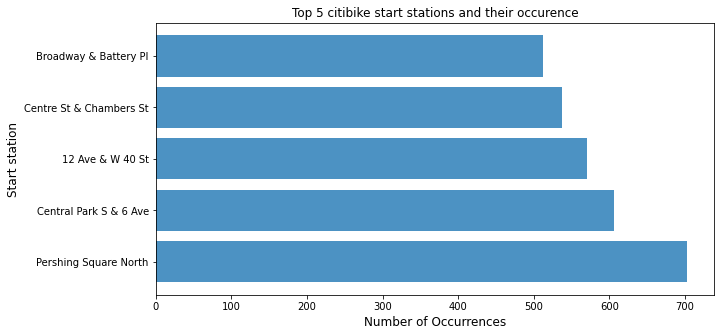

In [12]:
start_station_count = df['start station name'].value_counts()
start_station_count = start_station_count[:5,]

plt.figure(figsize=(10,5))
plt.barh(start_station_count.index, start_station_count.values,alpha=0.8)

plt.title('Top 5 citibike start stations and their occurence')
plt.ylabel('Start station', fontsize=12)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.show()

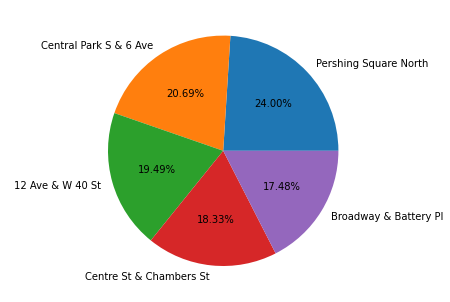

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(start_station_count.values, labels=start_station_count.index, autopct='%1.2f%%' )
plt.show()

##4. Top 5 citibike end stations

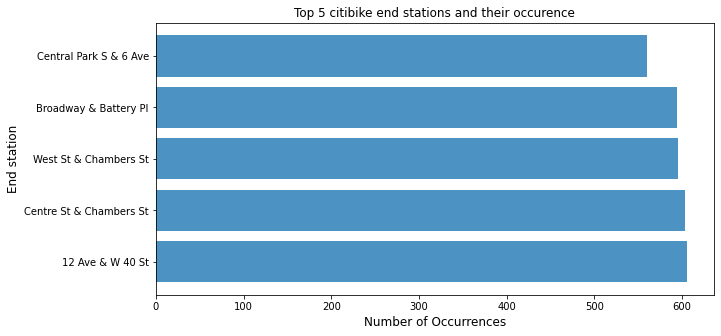

In [14]:
end_station_count = df['end station name'].value_counts()
end_station_count = end_station_count[:5,]

plt.figure(figsize=(10,5))
plt.barh(end_station_count.index, end_station_count.values, alpha=0.8)

plt.title('Top 5 citibike end stations and their occurence')
plt.ylabel('End station', fontsize=12)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.show()

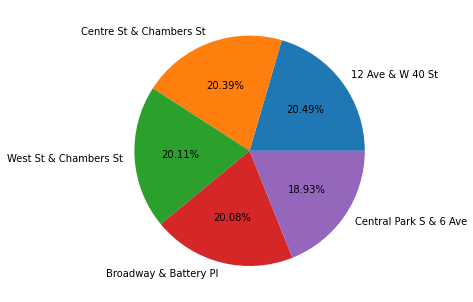

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(end_station_count.values, labels=end_station_count.index, autopct='%1.2f%%' )
plt.show()

##5. Visualizations

In [16]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
customer_type_df = pd.DataFrame(data=df['usertype'].value_counts())
customer_type_df = customer_type_df.reset_index()
customer_type_df.rename(columns={'usertype':'count', 'index': 'usertype'}, inplace=True)
layout = go.Layout(title='User Type',)
trace = go.Pie(labels=customer_type_df['usertype'].values, values=customer_type_df['count'].values)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

y = list(range(0, 110, 10))
men_bins = []
women_bins = []
for i in range(0, len(y) - 1):
    df_gender = pd.DataFrame(data=df[( df['age'] >  y[i] ) & (df['age'] < y[i+1]) ]['gender'].value_counts())
    df_gender = df_gender.reset_index()
    df_gender.rename(columns={'gender':'count', 'index':'gender'}, inplace=True)
    count = df_gender[df_gender['gender'] == 1]['count']
    men_bins.append(0 if len(count) == 0 else count.values[0])
    count2 = df_gender[df_gender['gender'] == 2]['count']
    women_bins.append(0 if len(count2) == 0 else -count2.values[0])
    
layout = go.Layout(yaxis=go.layout.YAxis(title='Age'),
                  title="Gender",
                   barmode='overlay',
                   bargap=0.1)

data = [
        go.Bar(y=y,
               x=women_bins,
               orientation='h',
               name='Women',
               text=-1 * women_bins,
               hoverinfo='text',
               marker=dict(color='seagreen')
               ),go.Bar(y=y,
               x=men_bins,
               orientation='h',
               name='Men',
               hoverinfo='x',
               marker=dict(color='powderblue')
               )]
iplot(dict(data=data, layout=layout))

# in pie chart
# 1= subscriber
# 0= customer

##6. Busiest Bike

In [46]:
minutes = df['tripduration']/60
df['speed'] = df['distance']/minutes

bike_use_df = df.groupby(['bikeid']).size().reset_index(name = 'Number of Times Used')
bike_use_df = bike_use_df.sort_values('Number of Times Used', ascending = False)
bike_use_df = bike_use_df.head()
bike_use_df

,bikeid,Number of Times Used
9010,32767,34
8998,32755,29
9215,32993,27
9249,33027,27
8569,32294,26


###Therefore, busiest bike is bike id 32767 which is used 34 times in the month of February.

In [18]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,distance,weekpart,daypart,age,speed
0,2359,2018-02-01 10:36:18.8480,2018-02-01 11:15:38.0000,72,W 52 St & 11 Ave,40.767272,-73.993929,3435,Grand St & Elizabeth St,40.718822,-73.995960,32217,1,1959,2,7.438101,3,1,59,0.189184
1,1574,2018-02-02 15:31:55.8670,2018-02-02 15:58:10.1810,72,W 52 St & 11 Ave,40.767272,-73.993929,490,8 Ave & W 33 St,40.751551,-73.993934,29907,1,1954,1,7.438101,4,2,64,0.283536
2,2283,2018-02-03 10:12:06.6800,2018-02-03 10:50:09.9680,72,W 52 St & 11 Ave,40.767272,-73.993929,3435,Grand St & Elizabeth St,40.718822,-73.995960,16636,1,1966,2,7.438101,5,1,52,0.195482
3,1803,2018-02-03 16:21:32.3630,2018-02-03 16:51:36.3610,72,W 52 St & 11 Ave,40.767272,-73.993929,309,Murray St & West St,40.714979,-74.013012,31787,1,1957,1,7.438101,5,2,61,0.247524
4,1567,2018-02-03 17:25:55.6610,2018-02-03 17:52:03.3800,72,W 52 St & 11 Ave,40.767272,-73.993929,236,St Marks Pl & 2 Ave,40.728419,-73.987140,32055,1,1984,1,7.438101,5,2,34,0.284803


##7. Stolen Bikes
Any trip which lasts longer than 1 hours (3,600 seconds) probably indicates a stolen bike, an anomaly, or incorrect docking of the bike. No rider would plan to go over the maximum 45 minutes allowed. 

In [19]:
stolen_bikes = df[df['tripduration']>3600]
f= ['bikeid', 'tripduration']
stolen_bikes_id = stolen_bikes[f]
stolen_bikes_id = stolen_bikes_id.reset_index()
stolen_bikes_id = stolen_bikes_id.drop(['index'],axis=1)
stolen_bikes_id.head()


,bikeid,tripduration
0,19912,66057
1,15554,3739
2,18314,47843
3,16242,6251
4,32174,5567


###Therefore, we can say that bike id 19912, 15554, 18314, 16242, 32174 are stolen.

##8. Model application

In [20]:
features = ['tripduration','weekpart','daypart','usertype','age', 'gender', 'distance', 'speed']
df1 = df[features]
df1.head()

,tripduration,weekpart,daypart,usertype,age,gender,distance,speed
0,2359,3,1,1,59,2,7.438101,0.189184
1,1574,4,2,1,64,1,7.438101,0.283536
2,2283,5,1,1,52,2,7.438101,0.195482
3,1803,5,2,1,61,1,7.438101,0.247524
4,1567,5,2,1,34,1,7.438101,0.284803


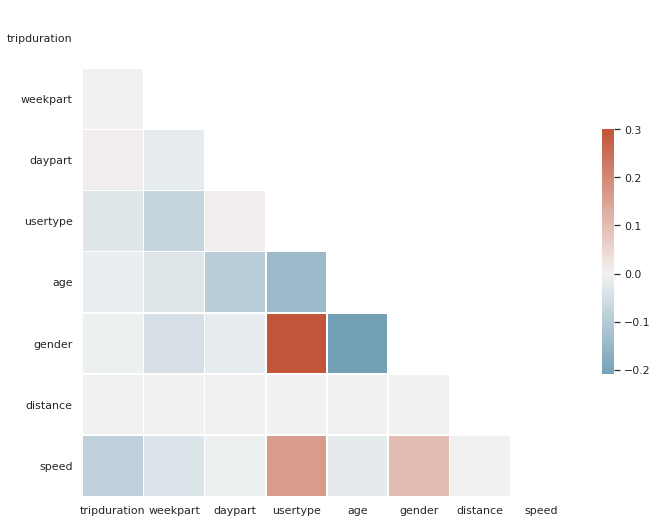

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

corr = df1.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

##Feature engineering

In [22]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
predictors = ['weekpart','daypart','usertype','age', 'gender', 'distance', 'speed']
X = df[predictors]
y = df['tripduration']

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=42)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(50056, 7) (21453, 7) (50056,) (21453,)


In [23]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression


In [24]:
model = RandomForestRegressor(n_estimators=100,max_depth=25)
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [25]:
print(model.score(x_train,y_train))
print(model.score(x_test,y_test))

0.9915779465497001
0.9979980985308738


In [26]:
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
print(model.score(x_train,y_train))
print(model.score(x_test,y_test))

0.0079602966199801
0.007492669073952851


In [28]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=1.0)
model.fit(x_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
print(model.score(x_train,y_train))
print(model.score(x_test,y_test))

0.007960272025823723
0.007499367257917444


##Accuracy for predicting tripduration
1. Random Forest Regression = 99.79%
2. Linear Regression = 0.75%
3. Lasso Regression = 0.75%

Therefore, Random forest regression technique suits best for this model. Linear and Lasso regression failed as the data might have non linearity.

###Models to predict the gender of the user based on the features 'weekpart', 'daypart', 'usertype', 'age',  'distance', 'tripduration'.

In [30]:
predictors1 = ['weekpart','daypart','usertype','age', 'distance', 'tripduration', 'speed']
x1 = df[predictors1]
y1 = df['gender']

x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size = 0.3,random_state=42)
print(x1_train.shape,x1_test.shape,y1_train.shape,y1_test.shape)

(50056, 7) (21453, 7) (50056,) (21453,)


In [32]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier()
    ]

from sklearn.metrics import confusion_matrix
for classifier in classifiers:
  model = classifier.fit(x1_train, y1_train)
  print(classifier)
  print("model score: %.3f" % model.score(x1_test, y1_test))
  y1_pred = classifier.predict(x1_test)
  print("----------------------------------------------------------------------------------------------------------------------")
  print(confusion_matrix(y1_test, y1_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
model score: 0.648
----------------------------------------------------------------------------------------------------------------------
[[ 2873   231    46]
 [  999 10162  2169]
 [  365  3739   869]]
SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
model score: 0.621
----------------------------------------------------------------------------------------------------------------------
[[    0  3150     0]
 [    0 13330     0]
 [    0  4973     0]]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
    

##Accuracy for predicting gender
1. KNN = 64.8%
2. SVC = 62.1%
3. Decision Tree = 65.4%
4. Random Forest Classifier = 71%

The highest accuracy is given by Random Forest Classifier as it adapts non-linearity. It is constructed of many trees, with different sampling, it could work on dataset with great variance. 

The second highest accuracy is given by Decision tree. The reason is same as Random forest because random forest is a forest of decision trees.

##Prediction using KNN classifier, SVC, Decision tree and Random forest
example set:

tripduration:	2359 	

daypart:1	

age:1	

weekpart: 3

distance: 7.438101

speed: 0.189184

gender: 2

In [51]:
example_gender = [['3',	'1',	'1',	'59', '7.438101', '2359',	'0.189184']]
target_name = [0,1,2]
print('Predicted gender for ', example_gender, ' using KNN classifier is ', target_name[classifiers[0].predict(example_gender)[0]])

Predicted gender for  [['3', '1', '1', '59', '7.438101', '2359', '0.189184']]  is  2


/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:171: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).

/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_base.py:605: FutureWarning:

Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).



In [55]:
print('Predicted gender for ', example_gender, ' using SVC is ', target_name[classifiers[1].predict(example_gender)[0]])

Predicted gender for  [['3', '1', '1', '59', '7.438101', '2359', '0.189184']]  using SVC is  1


In [52]:
print('Predicted gender for ', example_gender, ' using Decision tree classifier is ', target_name[classifiers[2].predict(example_gender)[0]])

Predicted gender for  [['3', '1', '1', '59', '7.438101', '2359', '0.189184']]  using Decision tree classifier is  2


In [54]:
print('Predicted gender for ', example_gender, ' using Random Forest classifier is ', target_name[classifiers[3].predict(example_gender)[0]])

Predicted gender for  [['3', '1', '1', '59', '7.438101', '2359', '0.189184']]  using Random Forest classifier is  2


##Hence, the prediction is correct for every classifier except for SVC since accuracy of SVC is least.